# 📊 Analisi PACF per Ottimizzazione Lag Features - T1 Diabetes

Questo notebook esegue un'analisi della **Partial Autocorrelation Function (PACF)** sui dati di glucosio dei pazienti diabetici per determinare il numero ottimale di lag features da utilizzare in modelli predittivi.

## Obiettivi:

- Calcolare la PACF per ogni paziente
- Visualizzare graficamente i lag significativi
- Determinare il numero ottimale di lag features


## 1. Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
import os
from IPython.display import display, HTML

warnings.filterwarnings("ignore")

print("✅ Librerie importate con successo!")

✅ Librerie importate con successo!


## 2. Define Data Loading Function


In [2]:
def load_glucose_data():
    """
    Carica e prepara i dati di glucosio per l'analisi PACF.

    Returns:
        pd.DataFrame: Dataset preparato con timestamp convertiti
    """
    print("🔄 Caricamento dati...")

    # Carica i dati
    df = pd.read_csv("data/T1DiabetesGranada/Glucose_measurements_corrected.csv")

    print(f"✅ Dataset caricato: {df.shape[0]} righe, {df.shape[1]} colonne")
    print(f"📋 Colonne: {df.columns.tolist()}")

    # Converti timestamp
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.sort_values(["Patient_ID", "Timestamp"])

    # Ottieni informazioni sui pazienti
    patients = df["Patient_ID"].unique()
    print(f"👥 Pazienti trovati: {len(patients)}")
    print(f"📈 Range ID pazienti: {patients.min()} - {patients.max()}")

    return df


# Carica i dati
df = load_glucose_data()

🔄 Caricamento dati...
✅ Dataset caricato: 31057929 righe, 3 colonne
📋 Colonne: ['Patient_ID', 'Timestamp', 'Measurement']
👥 Pazienti trovati: 689
📈 Range ID pazienti: 3263 - 4166


## 3. Define PACF Analysis Function with Visualization


In [3]:
def analyze_patient_pacf(
    patient_id, glucose_series, max_lags=50, significance_level=0.05, show_plot=True
):
    """
    Analizza la PACF per un singolo paziente e genera visualizzazione.

    Args:
        patient_id: ID del paziente
        glucose_series: Serie temporale del glucosio
        max_lags: Numero massimo di lag da analizzare
        significance_level: Livello di significatività
        show_plot: Se mostrare il grafico PACF

    Returns:
        dict: Risultati dell'analisi PACF
    """

    # Calcola statistiche di base
    patient_stats = {
        "n_measurements": len(glucose_series),
        "mean_glucose": glucose_series.mean(),
        "std_glucose": glucose_series.std(),
        "min_glucose": glucose_series.min(),
        "max_glucose": glucose_series.max(),
    }

    print(f"   📊 Misurazioni: {len(glucose_series)}")
    print(
        f"   📈 Range glucosio: {glucose_series.min():.1f} - {glucose_series.max():.1f}"
    )

    try:
        # Calcola PACF
        pacf_values, conf_int = pacf(
            glucose_series, nlags=max_lags, alpha=significance_level
        )

        # Il primo valore è sempre 1 (lag 0), quindi lo escludiamo
        pacf_values = pacf_values[1:]
        conf_int = conf_int[1:] if conf_int is not None else None

        # Trova il lag ottimale
        optimal_lag = find_optimal_lag(pacf_values, conf_int)

        # Visualizzazione
        if show_plot:
            create_pacf_plot(
                patient_id, glucose_series, pacf_values, conf_int, optimal_lag, max_lags
            )

        print(f"   🎯 Lag ottimale: {optimal_lag}")
        print(f"   📊 PACF(1): {pacf_values[0]:.3f}")
        if optimal_lag <= len(pacf_values):
            print(f"   📊 PACF({optimal_lag}): {pacf_values[optimal_lag-1]:.3f}")

        return {
            "pacf_values": pacf_values,
            "conf_int": conf_int,
            "optimal_lag": optimal_lag,
            "patient_stats": patient_stats,
            "success": True,
        }

    except Exception as e:
        print(f"   ❌ Errore nel calcolo PACF: {str(e)}")
        return {"success": False, "error": str(e), "patient_stats": patient_stats}


def find_optimal_lag(pacf_values, conf_int):
    """
    Trova il lag ottimale basato sui valori PACF e intervalli di confidenza.
    """
    optimal_lag = None

    if conf_int is not None:
        # Calcola i limiti di confidenza
        lower_bound = conf_int[:, 0] - pacf_values
        upper_bound = conf_int[:, 1] - pacf_values

        # Trova il primo lag dove PACF non è significativo
        for lag in range(len(pacf_values)):
            if abs(pacf_values[lag]) < abs(upper_bound[lag]) and abs(
                pacf_values[lag]
            ) < abs(lower_bound[lag]):
                optimal_lag = lag + 1  # +1 perché abbiamo escluso lag 0
                break

    # Se non troviamo un cutoff, usiamo il lag dove PACF scende sotto 0.1
    if optimal_lag is None:
        for lag in range(len(pacf_values)):
            if abs(pacf_values[lag]) < 0.1:
                optimal_lag = lag + 1
                break

    # Se ancora None, usiamo un valore di default
    if optimal_lag is None:
        optimal_lag = min(20, len(pacf_values))

    return optimal_lag


def create_pacf_plot(
    patient_id, glucose_series, pacf_values, conf_int, optimal_lag, max_lags
):
    """
    Crea un grafico PACF dettagliato per il paziente.
    """
    fig, ax = plt.subplots(facecolor="white")

    # PACF Plot
    # Usa plot_pacf di statsmodels per un grafico professionale
    plot_pacf(
        glucose_series,
        lags=max_lags,
        ax=ax,
        alpha=0.05,
        title=f"📊 Partial Autocorrelation Function - Paziente {patient_id}",
    )

    # Aggiungi linea verticale per il lag ottimale
    ax.axvline(
        x=optimal_lag,
        color="darkblue",
        linestyle="--",
        linewidth=2,
        label=f"Lag Ottimale: {optimal_lag}",
    )

    # Zoom per vedere meglio la striscia di confidenza
    # Imposta limiti Y per zoomare sulla zona di interesse
    ax.set_ylim(-0.5, 0.5)

    # Opzionale: limita anche l'asse X per focalizzarsi sui primi lag
    ax.set_xlim(0, min(15, max_lags))

    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # # Salva il grafico
    # os.makedirs("plots/pacf_analysis", exist_ok=True)
    # plt.savefig(
    #     f"plots/pacf_analysis/pacf_patient_{patient_id}.png",
    #     dpi=300,
    #     bbox_inches="tight",
    # )

    plt.show()


print("✅ Funzioni di analisi PACF definite!")

✅ Funzioni di analisi PACF definite!


## 5. Execute PACF Analysis for All Patients


🚀 Avvio analisi PACF completa...
📊 Analisi Partial Autocorrelation per ottimizzazione lag features

🔍 Inizio analisi PACF per 689 pazienti...
📊 Max lag considerati: 50
📈 Livello significatività: 0.05
📊 Mostrerò i grafici per i primi 5 pazienti validi

[1/689] 👤 Paziente 3263
   📊 Misurazioni: 59869
   📈 Range glucosio: 40.0 - 400.0


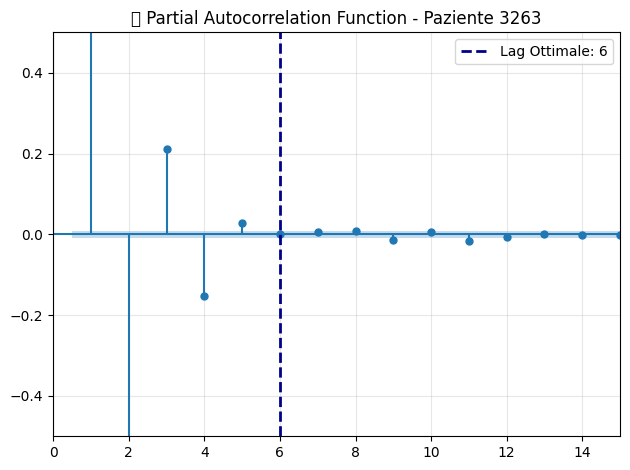

   🎯 Lag ottimale: 6
   📊 PACF(1): 0.981
   📊 PACF(6): -0.000

[2/689] 👤 Paziente 3264
   📊 Misurazioni: 26785
   📈 Range glucosio: 40.0 - 372.0


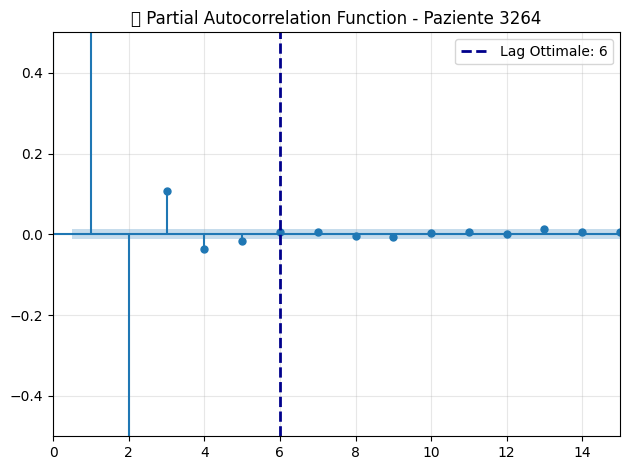

   🎯 Lag ottimale: 6
   📊 PACF(1): 0.979
   📊 PACF(6): 0.006

[3/689] 👤 Paziente 3265
   📊 Misurazioni: 46190
   📈 Range glucosio: 40.0 - 400.0


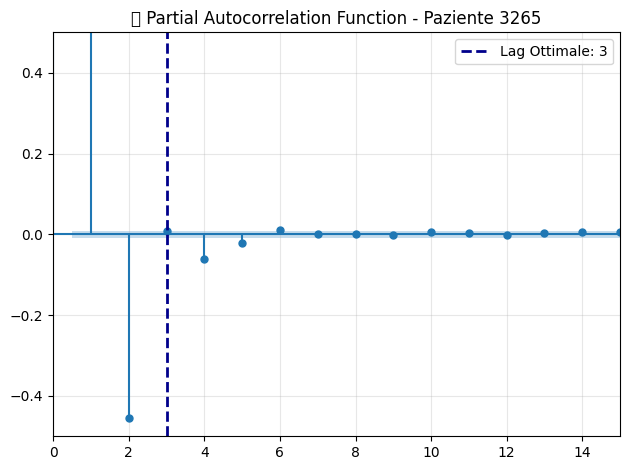

   🎯 Lag ottimale: 3
   📊 PACF(1): 0.979
   📊 PACF(3): 0.007

[4/689] 👤 Paziente 3266
   📊 Misurazioni: 44341
   📈 Range glucosio: 40.0 - 400.0


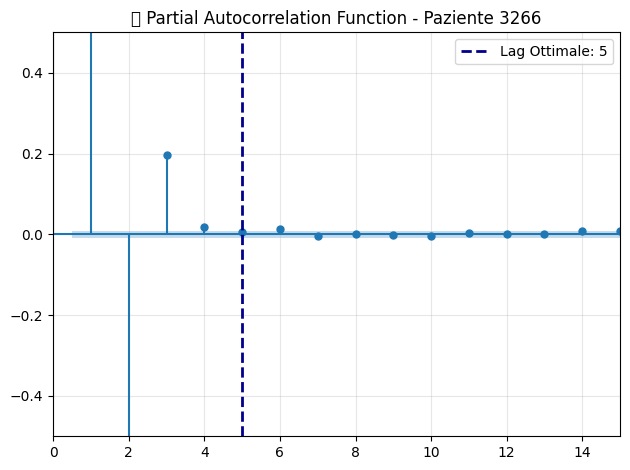

   🎯 Lag ottimale: 5
   📊 PACF(1): 0.950
   📊 PACF(5): 0.007

[5/689] 👤 Paziente 3267
   📊 Misurazioni: 54388
   📈 Range glucosio: 40.0 - 400.0


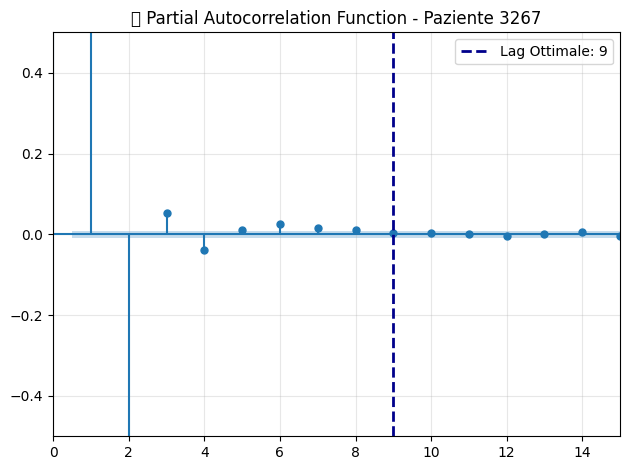

   🎯 Lag ottimale: 9
   📊 PACF(1): 0.973
   📊 PACF(9): 0.004

[6/689] 👤 Paziente 3268
   📊 Misurazioni: 41013
   📈 Range glucosio: 40.0 - 400.0
   🎯 Lag ottimale: 6
   📊 PACF(1): 0.970
   📊 PACF(6): -0.004

[7/689] 👤 Paziente 3269
   📊 Misurazioni: 71654
   📈 Range glucosio: 40.0 - 400.0
   🎯 Lag ottimale: 9
   📊 PACF(1): 0.971
   📊 PACF(9): -0.000

[8/689] 👤 Paziente 3272
   📊 Misurazioni: 3433
   📈 Range glucosio: 46.0 - 392.0
   🎯 Lag ottimale: 5
   📊 PACF(1): 0.973
   📊 PACF(5): 0.003

[9/689] 👤 Paziente 3273
   📊 Misurazioni: 16157
   📈 Range glucosio: 46.0 - 363.0
   🎯 Lag ottimale: 5
   📊 PACF(1): 0.955
   📊 PACF(5): -0.012

[10/689] 👤 Paziente 3274
   📊 Misurazioni: 11778
   📈 Range glucosio: 53.0 - 392.0
   🎯 Lag ottimale: 5
   📊 PACF(1): 0.969
   📊 PACF(5): 0.014

[11/689] 👤 Paziente 3277
   📊 Misurazioni: 114228
   📈 Range glucosio: 40.0 - 382.0
   🎯 Lag ottimale: 6
   📊 PACF(1): 0.962
   📊 PACF(6): -0.005

[12/689] 👤 Paziente 3278
   📊 Misurazioni: 3516
   📈 Range glucosio:

In [4]:
def run_complete_pacf_analysis(
    df, max_lags=50, significance_level=0.05, show_individual_plots=True, max_plots=10
):
    """
    Esegue l'analisi PACF completa per tutti i pazienti.

    Args:
        df: DataFrame con i dati di glucosio
        max_lags: Numero massimo di lag da analizzare
        significance_level: Livello di significatività
        show_individual_plots: Se mostrare i grafici individuali
        max_plots: Numero massimo di grafici da mostrare

    Returns:
        tuple: (pacf_results, optimal_lags, patient_stats, valid_patients)
    """
    print("📊 Analisi Partial Autocorrelation per ottimizzazione lag features")
    print("=" * 70)

    # Ottieni lista pazienti
    patients = df["Patient_ID"].unique()

    # Parametri per l'analisi
    print(f"\n🔍 Inizio analisi PACF per {len(patients)} pazienti...")
    print(f"📊 Max lag considerati: {max_lags}")
    print(f"📈 Livello significatività: {significance_level}")

    if show_individual_plots:
        print(f"📊 Mostrerò i grafici per i primi {max_plots} pazienti validi")

    # Dizionari per memorizzare i risultati
    pacf_results = {}
    optimal_lags = {}
    patient_stats = {}

    valid_patients = 0
    plots_shown = 0

    for i, patient_id in enumerate(patients):
        print(f"\n[{i+1}/{len(patients)}] 👤 Paziente {patient_id}")

        # Filtra dati per il paziente corrente
        patient_data = df[df["Patient_ID"] == patient_id].copy()
        patient_data = patient_data.sort_values("Timestamp")
        glucose_series = patient_data["Measurement"].dropna()

        # Controlla se abbiamo abbastanza dati
        if len(glucose_series) < max_lags + 10:  # Minimo dati necessari
            print(f"   ⚠️  Dati insufficienti (< {max_lags + 10}), skip")
            continue

        # # Decide se mostrare il plot
        show_plot = show_individual_plots and plots_shown < max_plots

        # Analizza il paziente
        result = analyze_patient_pacf(
            patient_id, glucose_series, max_lags, significance_level, show_plot
        )

        if result["success"]:
            pacf_results[patient_id] = result["pacf_values"]
            optimal_lags[patient_id] = result["optimal_lag"]
            patient_stats[patient_id] = result["patient_stats"]
            valid_patients += 1

            if show_plot:
                plots_shown += 1
        else:
            print(f"   ❌ Analisi fallita per paziente {patient_id}")

    print(f"\n✅ Analisi completata per {valid_patients}/{len(patients)} pazienti")

    return pacf_results, optimal_lags, patient_stats, valid_patients


# Esegui l'analisi completa
print("🚀 Avvio analisi PACF completa...")
pacf_results, optimal_lags, patient_stats, valid_patients = run_complete_pacf_analysis(
    df, max_lags=50, show_individual_plots=True, max_plots=5
)

## 6. Generate Summary Statistics and Visualizations


In [5]:
def display_final_recommendations(optimal_lags, valid_patients):
    """
    Mostra le raccomandazioni finali per il feature engineering.
    """
    if not optimal_lags:
        print("❌ Nessun paziente valido trovato per l'analisi PACF")
        return

    lag_values = list(optimal_lags.values())

    # Crea una tabella riassuntiva
    summary_stats = {
        "Metrica": [
            "Media",
            "Mediana",
            "Deviazione Standard",
            "Minimo",
            "Massimo",
            "25° Percentile",
            "75° Percentile",
            "90° Percentile",
        ],
        "Valore": [
            f"{np.mean(lag_values):.1f}",
            f"{np.median(lag_values):.1f}",
            f"{np.std(lag_values):.1f}",
            f"{np.min(lag_values)}",
            f"{np.max(lag_values)}",
            f"{np.percentile(lag_values, 25):.1f}",
            f"{np.percentile(lag_values, 75):.1f}",
            f"{np.percentile(lag_values, 90):.1f}",
        ],
    }

    summary_df = pd.DataFrame(summary_stats)

    print("\n📊 Riassunto Statistico:")
    display(summary_df)


# Mostra raccomandazioni finali
recommended_lag = display_final_recommendations(optimal_lags, valid_patients)


📊 Riassunto Statistico:


,Metrica,Valore
0,Media,6.1
1,Mediana,6.0
2,Deviazione Standard,2.0
3,Minimo,3
4,Massimo,32
5,25° Percentile,5.0
6,75° Percentile,7.0
7,90° Percentile,8.0
